# 유럽의 기본소득 선호도 다중 분류 예측

데이터셋 출처: https://www.kaggle.com/daliaresearch/basic-income-survey-european-dataset/home

# Table of contents

1. 분석 배경

2. 분석 목적

3. EDA 및 전처리

4. 모델링

5. 결과 해석

## 1. 분석 배경 

코로나로 인한 재난지원금을 선별지급할지, 보편지급할지의 문제는 작년 큰 화두였습니다. 현재 4차 지원금을 앞두고 있는 시점에서는 선별 지원으로 결정이 되었는데요, 선별과 보편 복지에 대한 사람들의 생각에 영향을 주는 특성을 분석하고 싶어서 문제를 선택하게 되었습니다. 


## 2. 분석 목적 
1) 기본 소득에 찬성/반대하는 사람들을 예측하여 앞으로 기본 소득의 사회적 합의가 어떻게 될지 예측해서 정책 결정에 사용한다.

2) 기본 소득을 찬성/ 반대하는 사람들에게 영향을 주는 특성을 연구한다.

In [1]:
import pandas as pd

basic = pd.read_csv('https://raw.githubusercontent.com/terri1102/data_analysis_portfolio/main/basic_income_dataset_dalia.csv')
basic

,country_code,uuid,age,gender,rural,dem_education_level,dem_full_time_job,dem_has_children,question_bbi_2016wave4_basicincome_awareness,question_bbi_2016wave4_basicincome_vote,question_bbi_2016wave4_basicincome_effect,question_bbi_2016wave4_basicincome_argumentsfor,question_bbi_2016wave4_basicincome_argumentsagainst,age_group,weight
0,AT,f6e7ee00-deac-0133-4de8-0a81e8b09a82,61,male,rural,no,no,no,I know something about it,I would not vote,None of the above,None of the above,None of the above,40_65,1.105.534.474
1,AT,54f0f1c0-dda1-0133-a559-0a81e8b09a82,57,male,urban,high,yes,yes,I understand it fully,I would probably vote for it,A basic income would not affect my work choices,It increases appreciation for household work a...,It might encourage people to stop working,40_65,1.533.248.826
2,AT,83127080-da3d-0133-c74f-0a81e8b09a82,32,male,urban,NaN,no,no,I have heard just a little about it,I would not vote,‰Û_ gain additional skills,It creates more equality of opportunity,Foreigners might come to my country and take a...,26_39,0.9775919155
3,AT,15626d40-db13-0133-ea5c-0a81e8b09a82,45,male,rural,high,yes,yes,I have heard just a little about it,I would probably vote for it,‰Û_ work less,It reduces anxiety about financing basic needs,None of the above,40_65,1.105.534.474
4,AT,24954a70-db98-0133-4a64-0a81e8b09a82,41,female,urban,high,yes,yes,I have heard just a little about it,I would probably vote for it,None of the above,It reduces anxiety about financing basic needs,It is impossible to finance | It might encoura...,40_65,58.731.136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9644,SK,7d1ac020-dcb4-0133-817a-0a81e8b09a82,37,female,urban,high,yes,no,I understand it fully,I would probably vote for it,‰Û_ spend more time with my family,It reduces bureaucracy and administrative expe...,It is impossible to finance,26_39,0.4534108939
9645,SK,39f989f0-db52-0133-8482-0a81e8b09a82,53,male,urban,high,yes,yes,I have never heard of it,I would probably vote against it,A basic income would not affect my work choices,It reduces bureaucracy and administrative expe...,It might encourage people to stop working | On...,40_65,0.4261237973
9646,SK,70ce4a90-d965-0133-f5e4-0a81e8b09a82,24,male,urban,low,no,no,I have heard just a little about it,I would not vote,‰Û_ spend more time with my family,It reduces anxiety about financing basic needs,None of the above,14_25,0.6076881098
9647,SK,2896e440-db3c-0133-5b67-0a81e8b09a82,47,male,urban,low,yes,yes,I understand it fully,I would vote for it,A basic income would not affect my work choices,It reduces bureaucracy and administrative expe...,Foreigners might come to my country and take a...,40_65,0.8089441199


In [ ]:
basic.columns

Index(['country_code', 'uuid', 'age', 'gender', 'rural', 'dem_education_level',
       'dem_full_time_job', 'dem_has_children',
       'question_bbi_2016wave4_basicincome_awareness',
       'question_bbi_2016wave4_basicincome_vote',
       'question_bbi_2016wave4_basicincome_effect',
       'question_bbi_2016wave4_basicincome_argumentsfor',
       'question_bbi_2016wave4_basicincome_argumentsagainst', 'age_group',
       'weight'],
      dtype='object')

## 3. EDA 및 전처리

### 특성 이름 바꾸기

특성 이름이 복잡해서 짧게 바꾸어 주었습니다.

In [ ]:
basic.rename(columns = {'dem_education_level': 'education_level', 'dem_full_time_job': "full_time_job", 'dem_has_children': 'has_childeren', 
                      'question_bbi_2016wave4_basicincome_awareness': 'awareness', 'question_bbi_2016wave4_basicincome_vote': 'vote', 
                      'question_bbi_2016wave4_basicincome_effect': 'effect', 'question_bbi_2016wave4_basicincome_argumentsfor': 'pro',
                      'question_bbi_2016wave4_basicincome_argumentsagainst': 'con'}, inplace=True)
basic.columns

Index(['country_code', 'uuid', 'age', 'gender', 'rural', 'education_level',
       'full_time_job', 'has_childeren', 'awareness', 'vote', 'effect', 'pro',
       'con', 'age_group', 'weight'],
      dtype='object')

### 필요없는 특성 지우기

나이 특성과 겹치는 연령 그룹 특성, unique값인 id 특성, 설문조사에 없는 질문인 weight 특성을 제거하겠습니다. 하지만 weight는 모델 만들 때 클래스 비율을 고려하게 할 것이기에 따로 분리해서 보존하겠습니다.(미리 데이터셋 작성자가 타겟 클래스 비율을 계산해서 넣은 특성 같습니다.)

In [ ]:
weight = basic['weight']
weight

0       1.105.534.474
1       1.533.248.826
2        0.9775919155
3       1.105.534.474
4          58.731.136
            ...      
9644     0.4534108939
9645     0.4261237973
9646     0.6076881098
9647     0.8089441199
9648    1.050.687.192
Name: weight, Length: 9649, dtype: object

In [ ]:
basic = basic.drop(columns=['uuid','age_group','weight'])
basic

,country_code,age,gender,rural,education_level,full_time_job,has_childeren,awareness,vote,effect,pro,con
0,AT,61,male,rural,no,no,no,I know something about it,I would not vote,None of the above,None of the above,None of the above
1,AT,57,male,urban,high,yes,yes,I understand it fully,I would probably vote for it,A basic income would not affect my work choices,It increases appreciation for household work a...,It might encourage people to stop working
2,AT,32,male,urban,NaN,no,no,I have heard just a little about it,I would not vote,‰Û_ gain additional skills,It creates more equality of opportunity,Foreigners might come to my country and take a...
3,AT,45,male,rural,high,yes,yes,I have heard just a little about it,I would probably vote for it,‰Û_ work less,It reduces anxiety about financing basic needs,None of the above
4,AT,41,female,urban,high,yes,yes,I have heard just a little about it,I would probably vote for it,None of the above,It reduces anxiety about financing basic needs,It is impossible to finance | It might encoura...
...,...,...,...,...,...,...,...,...,...,...,...,...
9644,SK,37,female,urban,high,yes,no,I understand it fully,I would probably vote for it,‰Û_ spend more time with my family,It reduces bureaucracy and administrative expe...,It is impossible to finance
9645,SK,53,male,urban,high,yes,yes,I have never heard of it,I would probably vote against it,A basic income would not affect my work choices,It reduces bureaucracy and administrative expe...,It might encourage people to stop working | On...
9646,SK,24,male,urban,low,no,no,I have heard just a little about it,I would not vote,‰Û_ spend more time with my family,It reduces anxiety about financing basic needs,None of the above
9647,SK,47,male,urban,low,yes,yes,I understand it fully,I would vote for it,A basic income would not affect my work choices,It reduces bureaucracy and administrative expe...,Foreigners might come to my country and take a...


### 결측치 확인

In [ ]:
basic.isna().sum()/len(basic)

country_code       0.000000
age                0.000000
gender             0.000000
rural              0.000000
education_level    0.068712
full_time_job      0.000000
has_childeren      0.000000
awareness          0.000000
vote               0.000000
effect             0.000000
pro                0.000000
con                0.000000
dtype: float64

교육 수준 특성에만 결측치가 있습니다. 결측치 비율은 6%로 나중에 모델을 만들 때 imputer로 처리할 예정입니다.

### 중복값 확인

In [ ]:
basic.duplicated().sum()

29

In [ ]:
basic[basic.duplicated()]

,country_code,age,gender,rural,education_level,full_time_job,has_childeren,awareness,vote,effect,pro,con
198,BE,40,male,urban,high,yes,yes,I know something about it,I would probably vote for it,None of the above,It encourages financial independence and self-...,It is impossible to finance
1636,DE,42,male,rural,medium,yes,yes,I know something about it,I would vote for it,A basic income would not affect my work choices,It reduces anxiety about financing basic needs...,Foreigners might come to my country and take a...
2459,ES,42,male,urban,high,yes,yes,I understand it fully,I would vote for it,A basic income would not affect my work choices,It reduces anxiety about financing basic needs,None of the above
2562,ES,42,male,urban,high,yes,yes,I understand it fully,I would probably vote for it,A basic income would not affect my work choices,"It increases solidarity, because it is funded ...",Foreigners might come to my country and take a...
2770,ES,59,female,rural,high,yes,yes,I understand it fully,I would vote for it,A basic income would not affect my work choices,It reduces anxiety about financing basic needs,It is impossible to finance
3002,ES,19,male,rural,low,no,no,I have never heard of it,I would not vote,None of the above,None of the above,None of the above
3039,ES,49,female,urban,medium,yes,no,I understand it fully,I would vote against it,‰Û_ stop working,None of the above,It might encourage people to stop working
3105,ES,39,female,urban,high,yes,no,I have never heard of it,I would not vote,None of the above,None of the above,None of the above
3300,FI,52,male,urban,low,yes,yes,I understand it fully,I would vote for it,A basic income would not affect my work choices,It reduces bureaucracy and administrative expe...,Only the people who need it most should get so...
4431,FR,20,female,urban,medium,no,no,I have never heard of it,I would not vote,None of the above,None of the above,None of the above


중복값이라고 나온 샘플들을 보니 중복값이 아닌 것 같아 보입니다. 아무래도 답변이 줄글로 길어서 문장형 답이 같은 샘플들이 중복값으로 잡힌 것 같습니다.

### 이상치 확인

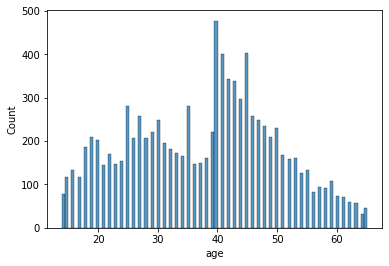

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(basic['age'], bins=100);

설문조사 설명에 명시된 대로 14세~65세 사이의 데이터로 이상치는 없습니다.

### High cardinality 확인

In [ ]:
basic.nunique()

country_code        28
age                 52
gender               2
rural                2
education_level      4
full_time_job        2
has_childeren        2
awareness            4
vote                 5
effect               9
pro                674
con                881
dtype: int64

기본 소득에 대한 의견을 묻는 질문들이 서술형이었던 것 같습니다. 답안들을 비슷한 그룹으로 묶어서 변환하는 작업이 필요할 것 같습니다.

In [ ]:
basic['pro'].head()

0                                    None of the above
1    It increases appreciation for household work a...
2              It creates more equality of opportunity
3       It reduces anxiety about financing basic needs
4       It reduces anxiety about financing basic needs
Name: pro, dtype: object

In [ ]:
basic['pro'].unique()[:20]

array(['None of the above',
       'It increases appreciation for household work and volunteering | It encourages financial independence and self-responsibility | It reduces anxiety about financing basic needs',
       'It creates more equality of opportunity',
       'It reduces anxiety about financing basic needs',
       'It encourages financial independence and self-responsibility | It reduces anxiety about financing basic needs',
       'It increases appreciation for household work and volunteering | It reduces anxiety about financing basic needs',
       'It creates more equality of opportunity | It reduces anxiety about financing basic needs | It reduces bureaucracy and administrative expenses',
       'It increases solidarity, because it is funded by everyone',
       'It increases appreciation for household work and volunteering',
       'It reduces anxiety about financing basic needs | It creates more equality of opportunity | It encourages financial independence and self-res

데이터를 살펴보니 서술형이 아니라 객관식 답안이었지만, 중복선택이 가능했던 것 같습니다.

답변은 이렇게 7가지가 있어서 원핫인코딩을 해야 할 것 같습니다. 

None of the above

It reduces anxiety about financing basic needs

It creates more equality of opportunity

It encourages financial independence and self-responsibility

It increases solidarity, because it is funded by everyone

It increases appreciation for household work and volunteering

It reduces bureaucracy and administrative expenses

In [ ]:
basic['con'].unique()[:20]

array(['None of the above', 'It might encourage people to stop working',
       'Foreigners might come to my country and take advantage of the benefit',
       'It is impossible to finance | It might encourage people to stop working | It increases dependence on the state',
       'It is impossible to finance | It might encourage people to stop working | It is against the principle of linking merit and reward',
       'Foreigners might come to my country and take advantage of the benefit | It might encourage people to stop working | It increases dependence on the state',
       'It might encourage people to stop working | Foreigners might come to my country and take advantage of the benefit | It is impossible to finance | Only the people who need it most should get something from the state',
       'Foreigners might come to my country and take advantage of the benefit | It is impossible to finance',
       'It is against the principle of linking merit and reward | It might encourage peo

기본 소득에 부정적인 의견도 7가지의 특성을 중복선택한 답입니다.

None of the above

It might encourage people to stop working 

It increases dependence on the state 

It is against the principle of linking merit and reward 

It is impossible to finance 

Foreigners might come to my country and take advantage of the benefit 

Only the people who need it most should get something from the state

In [ ]:
basic.head(5)

,country_code,age,gender,rural,education_level,full_time_job,has_childeren,awareness,vote,effect,pro,con
0,AT,61,male,rural,no,no,no,I know something about it,I would not vote,None of the above,None of the above,None of the above
1,AT,57,male,urban,high,yes,yes,I understand it fully,I would probably vote for it,A basic income would not affect my work choices,It increases appreciation for household work a...,It might encourage people to stop working
2,AT,32,male,urban,NaN,no,no,I have heard just a little about it,I would not vote,‰Û_ gain additional skills,It creates more equality of opportunity,Foreigners might come to my country and take a...
3,AT,45,male,rural,high,yes,yes,I have heard just a little about it,I would probably vote for it,‰Û_ work less,It reduces anxiety about financing basic needs,None of the above
4,AT,41,female,urban,high,yes,yes,I have heard just a little about it,I would probably vote for it,None of the above,It reduces anxiety about financing basic needs,It is impossible to finance | It might encoura...


In [ ]:
basic['pro'] = basic['pro'].astype('string')
basic.dtypes

country_code       object
age                 int64
gender             object
rural              object
education_level    object
full_time_job      object
has_childeren      object
awareness          object
vote               object
effect             object
pro                string
con                object
dtype: object

In [ ]:
basic['None'] = basic['pro'].apply(lambda x: 1 if 'None' in x else 0)

In [ ]:
basic['Reduce_anxiety'] = basic['pro'].apply(lambda x: 1 if 'anxiety' in x else 0)
basic['Equality'] = basic['pro'].apply(lambda x: 1 if 'equality' in x else 0)
basic['Financial_independence'] = basic['pro'].apply(lambda x: 1 if 'independence' in x else 0)
basic['Solidarity'] = basic['pro'].apply(lambda x: 1 if 'solidarity' in x else 0)
basic['Appreciation'] = basic['pro'].apply(lambda x: 1 if 'appreciation' in x else 0)
basic['Reduce_expenses'] = basic['pro'].apply(lambda x: 1 if 'bureaucracy' in x else 0)

In [ ]:
basic['None_con'] = basic['con'].apply(lambda x: 1 if 'None' in x else 0)
basic['Discouraging'] = basic['con'].apply(lambda x: 1 if 'encourage' in x else 0)
basic['Dependence'] = basic['con'].apply(lambda x: 1 if 'dependence' in x else 0)
basic['Against_merit_system'] = basic['con'].apply(lambda x: 1 if 'merit' in x else 0)
basic['Finance_prob'] = basic['con'].apply(lambda x: 1 if 'finance' in x else 0)
basic['Foreigners_job'] = basic['con'].apply(lambda x: 1 if 'Foreigners' in x else 0)
basic['Only_needed'] = basic['con'].apply(lambda x: 1 if 'Only' in x else 0)

In [ ]:
basic

,country_code,age,gender,rural,education_level,full_time_job,has_childeren,awareness,vote,effect,pro,con,None,Reduce_anxiety,Equality,Financial_independence,Solidarity,Appreciation,Reduce_expenses,None_con,Discouraging,Dependence,Against_merit_system,Finance_prob,Foreigners_job,Only_needed
0,AT,61,male,rural,no,no,no,I know something about it,I would not vote,None of the above,None of the above,None of the above,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,AT,57,male,urban,high,yes,yes,I understand it fully,I would probably vote for it,A basic income would not affect my work choices,It increases appreciation for household work a...,It might encourage people to stop working,0,1,0,1,0,1,0,0,1,0,0,0,0,0
2,AT,32,male,urban,NaN,no,no,I have heard just a little about it,I would not vote,‰Û_ gain additional skills,It creates more equality of opportunity,Foreigners might come to my country and take a...,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,AT,45,male,rural,high,yes,yes,I have heard just a little about it,I would probably vote for it,‰Û_ work less,It reduces anxiety about financing basic needs,None of the above,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,AT,41,female,urban,high,yes,yes,I have heard just a little about it,I would probably vote for it,None of the above,It reduces anxiety about financing basic needs,It is impossible to finance | It might encoura...,0,1,0,0,0,0,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9644,SK,37,female,urban,high,yes,no,I understand it fully,I would probably vote for it,‰Û_ spend more time with my family,It reduces bureaucracy and administrative expe...,It is impossible to finance,0,0,0,0,0,0,1,0,0,0,0,1,0,0
9645,SK,53,male,urban,high,yes,yes,I have never heard of it,I would probably vote against it,A basic income would not affect my work choices,It reduces bureaucracy and administrative expe...,It might encourage people to stop working | On...,0,0,0,0,0,0,1,0,1,0,1,0,0,1
9646,SK,24,male,urban,low,no,no,I have heard just a little about it,I would not vote,‰Û_ spend more time with my family,It reduces anxiety about financing basic needs,None of the above,0,1,0,0,0,0,0,1,0,0,0,0,0,0
9647,SK,47,male,urban,low,yes,yes,I understand it fully,I would vote for it,A basic income would not affect my work choices,It reduces bureaucracy and administrative expe...,Foreigners might come to my country and take a...,0,1,1,1,0,1,1,0,0,0,0,0,1,0


원핫인코딩 후 원래의 찬/반 특성은 새로 만든 특성들과 중복되기 때문에 제거해줍니다.

In [ ]:
basic = basic.drop(columns=['pro','con'])
basic.columns

Index(['country_code', 'age', 'gender', 'rural', 'education_level',
       'full_time_job', 'has_childeren', 'awareness', 'vote', 'effect', 'None',
       'Reduce_anxiety', 'Equality', 'Financial_independence', 'Solidarity',
       'Appreciation', 'Reduce_expenses', 'None_con', 'Discouraging',
       'Dependence', 'Against_merit_system', 'Finance_prob', 'Foreigners_job',
       'Only_needed'],
      dtype='object')

In [ ]:
basic.effect.unique()

array(['None of the above',
       'A basic income would not affect my work choices',
       '‰Û_ gain additional skills', '‰Û_ work less',
       '‰Û_ work as a freelancer', '‰Û_ do more volunteering work',
       '‰Û_ stop working', '‰Û_ spend more time with my family',
       '‰Û_ look for a different job'], dtype=object)

답변에 이상한 문자가 들어갔지만 나중에 인코딩할 것이기에 그냥 두겠습니다.

### 타겟 분포 확인

In [ ]:
basic['vote'].value_counts()

I would probably vote for it        3272
I would vote for it                 2819
I would probably vote against it    1439
I would not vote                    1159
I would vote against it              960
Name: vote, dtype: int64

기본 소득을 지지하는 투표를 할 것이라고 한 인원이 많아보입니다.

## 4. 모델링

In [ ]:
target = 'vote'
features = basic.drop(columns=target).columns

from sklearn.model_selection import train_test_split

train, val = train_test_split(basic, train_size=0.7, random_state = 2, stratify=basic[target])

In [ ]:
train['vote'].value_counts()

I would probably vote for it        2291
I would vote for it                 1973
I would probably vote against it    1007
I would not vote                     811
I would vote against it              672
Name: vote, dtype: int64

In [ ]:
train.shape, val.shape

((6754, 24), (2895, 24))

멀티 클래스 모델을 만들 때는 클래스를 0,1,2...이런 식으로 인코딩해야 하기에 클래스를 숫자로 맵핑해줍니다.

In [ ]:
train['vote'].replace({'I would vote against it':0, 'I would probably vote against it':1, 
                                       'I would not vote':2, 'I would probably vote for it':3, 'I would vote for it':4}, inplace=True)
train

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,country_code,age,gender,rural,education_level,full_time_job,has_childeren,awareness,vote,effect,None,Reduce_anxiety,Equality,Financial_independence,Solidarity,Appreciation,Reduce_expenses,None_con,Discouraging,Dependence,Against_merit_system,Finance_prob,Foreigners_job,Only_needed
4022,FR,53,female,urban,low,no,yes,I know something about it,2,A basic income would not affect my work choices,1,0,0,0,0,0,0,0,1,0,1,0,0,1
8219,PL,50,female,urban,high,yes,yes,I have heard just a little about it,3,‰Û_ work as a freelancer,0,0,1,0,0,0,0,0,1,0,0,1,0,0
4485,FR,44,male,rural,high,yes,no,I understand it fully,3,‰Û_ look for a different job,0,0,1,0,0,0,0,0,0,0,0,0,1,0
9498,SE,35,male,rural,low,no,no,I understand it fully,3,‰Û_ gain additional skills,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5113,GB,40,female,rural,high,yes,yes,I know something about it,3,‰Û_ work less,0,0,1,0,1,0,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,FR,48,female,urban,low,no,yes,I know something about it,0,‰Û_ look for a different job,1,0,0,0,0,0,0,0,0,0,1,0,0,0
6219,HU,30,male,urban,medium,yes,no,I have heard just a little about it,3,A basic income would not affect my work choices,0,0,1,1,0,1,0,0,0,0,0,0,0,1
3448,FR,37,female,urban,NaN,no,yes,I understand it fully,2,None of the above,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3806,FR,52,male,urban,medium,yes,yes,I understand it fully,3,A basic income would not affect my work choices,1,0,0,0,0,0,0,0,1,0,0,1,1,0


In [ ]:
val['vote'].replace({'I would vote against it':0, 'I would probably vote against it':1, 
                                       'I would not vote':2, 'I would probably vote for it':3, 'I would vote for it':4}, inplace=True)
val

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,country_code,age,gender,rural,education_level,full_time_job,has_childeren,awareness,vote,effect,None,Reduce_anxiety,Equality,Financial_independence,Solidarity,Appreciation,Reduce_expenses,None_con,Discouraging,Dependence,Against_merit_system,Finance_prob,Foreigners_job,Only_needed
1177,DE,53,male,urban,low,yes,yes,I have heard just a little about it,1,‰Û_ do more volunteering work,0,0,0,0,0,0,1,0,1,0,1,1,1,1
3519,FR,63,male,urban,low,yes,yes,I understand it fully,3,A basic income would not affect my work choices,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3823,FR,32,female,urban,high,yes,no,I know something about it,4,‰Û_ work less,0,1,1,1,1,1,1,0,0,0,0,0,1,0
116,AT,39,female,rural,medium,no,yes,I have heard just a little about it,2,‰Û_ spend more time with my family,1,0,0,0,0,0,0,1,0,0,0,0,0,0
243,BE,56,female,urban,NaN,no,no,I understand it fully,4,‰Û_ look for a different job,0,1,1,1,1,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,FR,27,female,urban,no,no,no,I understand it fully,3,None of the above,0,0,0,0,0,1,0,1,0,0,0,0,0,0
3915,FR,42,male,urban,medium,yes,yes,I know something about it,3,A basic income would not affect my work choices,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3246,FI,54,female,urban,medium,yes,yes,I understand it fully,3,A basic income would not affect my work choices,0,0,1,0,0,1,0,0,0,1,0,1,1,1
1254,DE,46,female,rural,NaN,no,no,I know something about it,1,A basic income would not affect my work choices,0,1,0,1,0,0,0,0,1,0,0,0,1,1


In [ ]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [ ]:
y_train.value_counts()

3    2291
4    1973
1    1007
2     811
0     672
Name: vote, dtype: int64

In [ ]:
y_val.value_counts()

3    981
4    846
1    432
2    348
0    288
Name: vote, dtype: int64

In [ ]:
!pip install category_encoders

In [ ]:
#label size predict size not match->멀티 클래스 모델을 auc, aucpr로 평가하려고 하면 생기는 버그

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent') #결측치가 범주형 특성이어서 최빈값으로 넣겠습니다.
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

X_train_df = pd.DataFrame(X_train_processed, columns = X_train.columns)
X_val_df = pd.DataFrame(X_val_processed, columns = X_val.columns)

eval_set = [(X_train_df, y_train), 
            (X_val_df, y_val)]

# XGBoost 분류기를 학습
model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, objective='multi:prob', scale_pos_weight=weight) #'multi:prob', multi:softmax
model.fit(X_train_df, y_train, eval_set=eval_set, eval_metric='mlogloss', early_stopping_rounds= 20) #multiclass는 auc, aucpr 작동 안함->"mlogloss" or "merror" 사용

[0]	validation_0-mlogloss:1.56482	validation_1-mlogloss:1.56605
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:1.52674	validation_1-mlogloss:1.52934
[2]	validation_0-mlogloss:1.49392	validation_1-mlogloss:1.49766
[3]	validation_0-mlogloss:1.46535	validation_1-mlogloss:1.4702
[4]	validation_0-mlogloss:1.44034	validation_1-mlogloss:1.44583
[5]	validation_0-mlogloss:1.4182	validation_1-mlogloss:1.42481
[6]	validation_0-mlogloss:1.39863	validation_1-mlogloss:1.40593
[7]	validation_0-mlogloss:1.38109	validation_1-mlogloss:1.38927
[8]	validation_0-mlogloss:1.36564	validation_1-mlogloss:1.37433
[9]	validation_0-mlogloss:1.35126	validation_1-mlogloss:1.36073
[10]	validation_0-mlogloss:1.33829	validation_1-mlogloss:1.34836
[11]	validation_0-mlogloss:1.32688	validation_1-mlogloss:1.33763
[12]	validation_0-mlogloss:1.31659	validation_1-mlogloss:1.32799


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0       1.105.534.474
1       1.533.248.826
2        0.9775919155
3       1.105.534.474
4          58.731.136
            ...      
9644     0.4534108939
9645     0.4261237973
9646     0.6076881098
9647     0.8089441199
9648    1.050.687.192
Name: weight, Length: 9649, dtype: object,
              seed=None, silent=None, subsample=1, verbosity=0)

In [ ]:
model.classes_

array([0, 1, 2, 3, 4])

## 5. 결과해석

In [ ]:
model.predict_proba(X_val_df)

array([[0.32953015, 0.34284538, 0.04563746, 0.23253064, 0.0494564 ],
       [0.02170303, 0.1278339 , 0.05034935, 0.47177455, 0.3283392 ],
       [0.00288121, 0.02580107, 0.02601698, 0.41361538, 0.53168535],
       ...,
       [0.04718891, 0.14571574, 0.01638206, 0.36398536, 0.42672795],
       [0.01384555, 0.16444406, 0.02535653, 0.52729166, 0.26906222],
       [0.3866466 , 0.2102501 , 0.09649397, 0.21590497, 0.09070434]],
      dtype=float32)

In [ ]:
from sklearn.metrics import roc_auc_score
#X_val_processed = processor.transform(X_val)
#class_index = 6
y_pred_proba = model.predict_proba(X_val_df) #[:, class_index]
#print(f'Test AUC for class "{model.classes_[class_index]}":')
print(roc_auc_score(y_val, y_pred_proba, average='macro', multi_class = 'ovo')) #One-vs-one이 클래스 불균형에 더 robust하다고 함

0.7809950082707441


AUC 점수는 0.78이 나오는데 이는 특성 하나하나를 비교하는 방법(one vs one)으로 계산된 것입니다. 다른 방법으로는 one vs rest 방법이 있는데, 이는 클래스 불균형에 취약하다고 해서 이번 과제에서는 one vs one 방법을 사용해봤습니다.

### 나이 특성과 타겟의 관계

기본소득에 대한 의견이 나이에 어떤 영향을 받는지 알아보기 위해 PDP plot으르 그려보았습니다.

In [ ]:
#!pip install pdpbox

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144
from pdpbox.pdp import pdp_isolate, pdp_plot

feature1 = 'age'

In [ ]:
X_val_df.columns

Index(['country_code', 'age', 'gender', 'rural', 'education_level',
       'full_time_job', 'has_childeren', 'awareness', 'effect', 'None',
       'Reduce_anxiety', 'Equality', 'Financial_independence', 'Solidarity',
       'Appreciation', 'Reduce_expenses', 'None_con', 'Discouraging',
       'Dependence', 'Against_merit_system', 'Finance_prob', 'Foreigners_job',
       'Only_needed'],
      dtype='object')

In [ ]:
isolated = pdp_isolate(
    model=model, 
    dataset=X_val_df, 
    model_features=X_val_df.columns, feature= feature1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


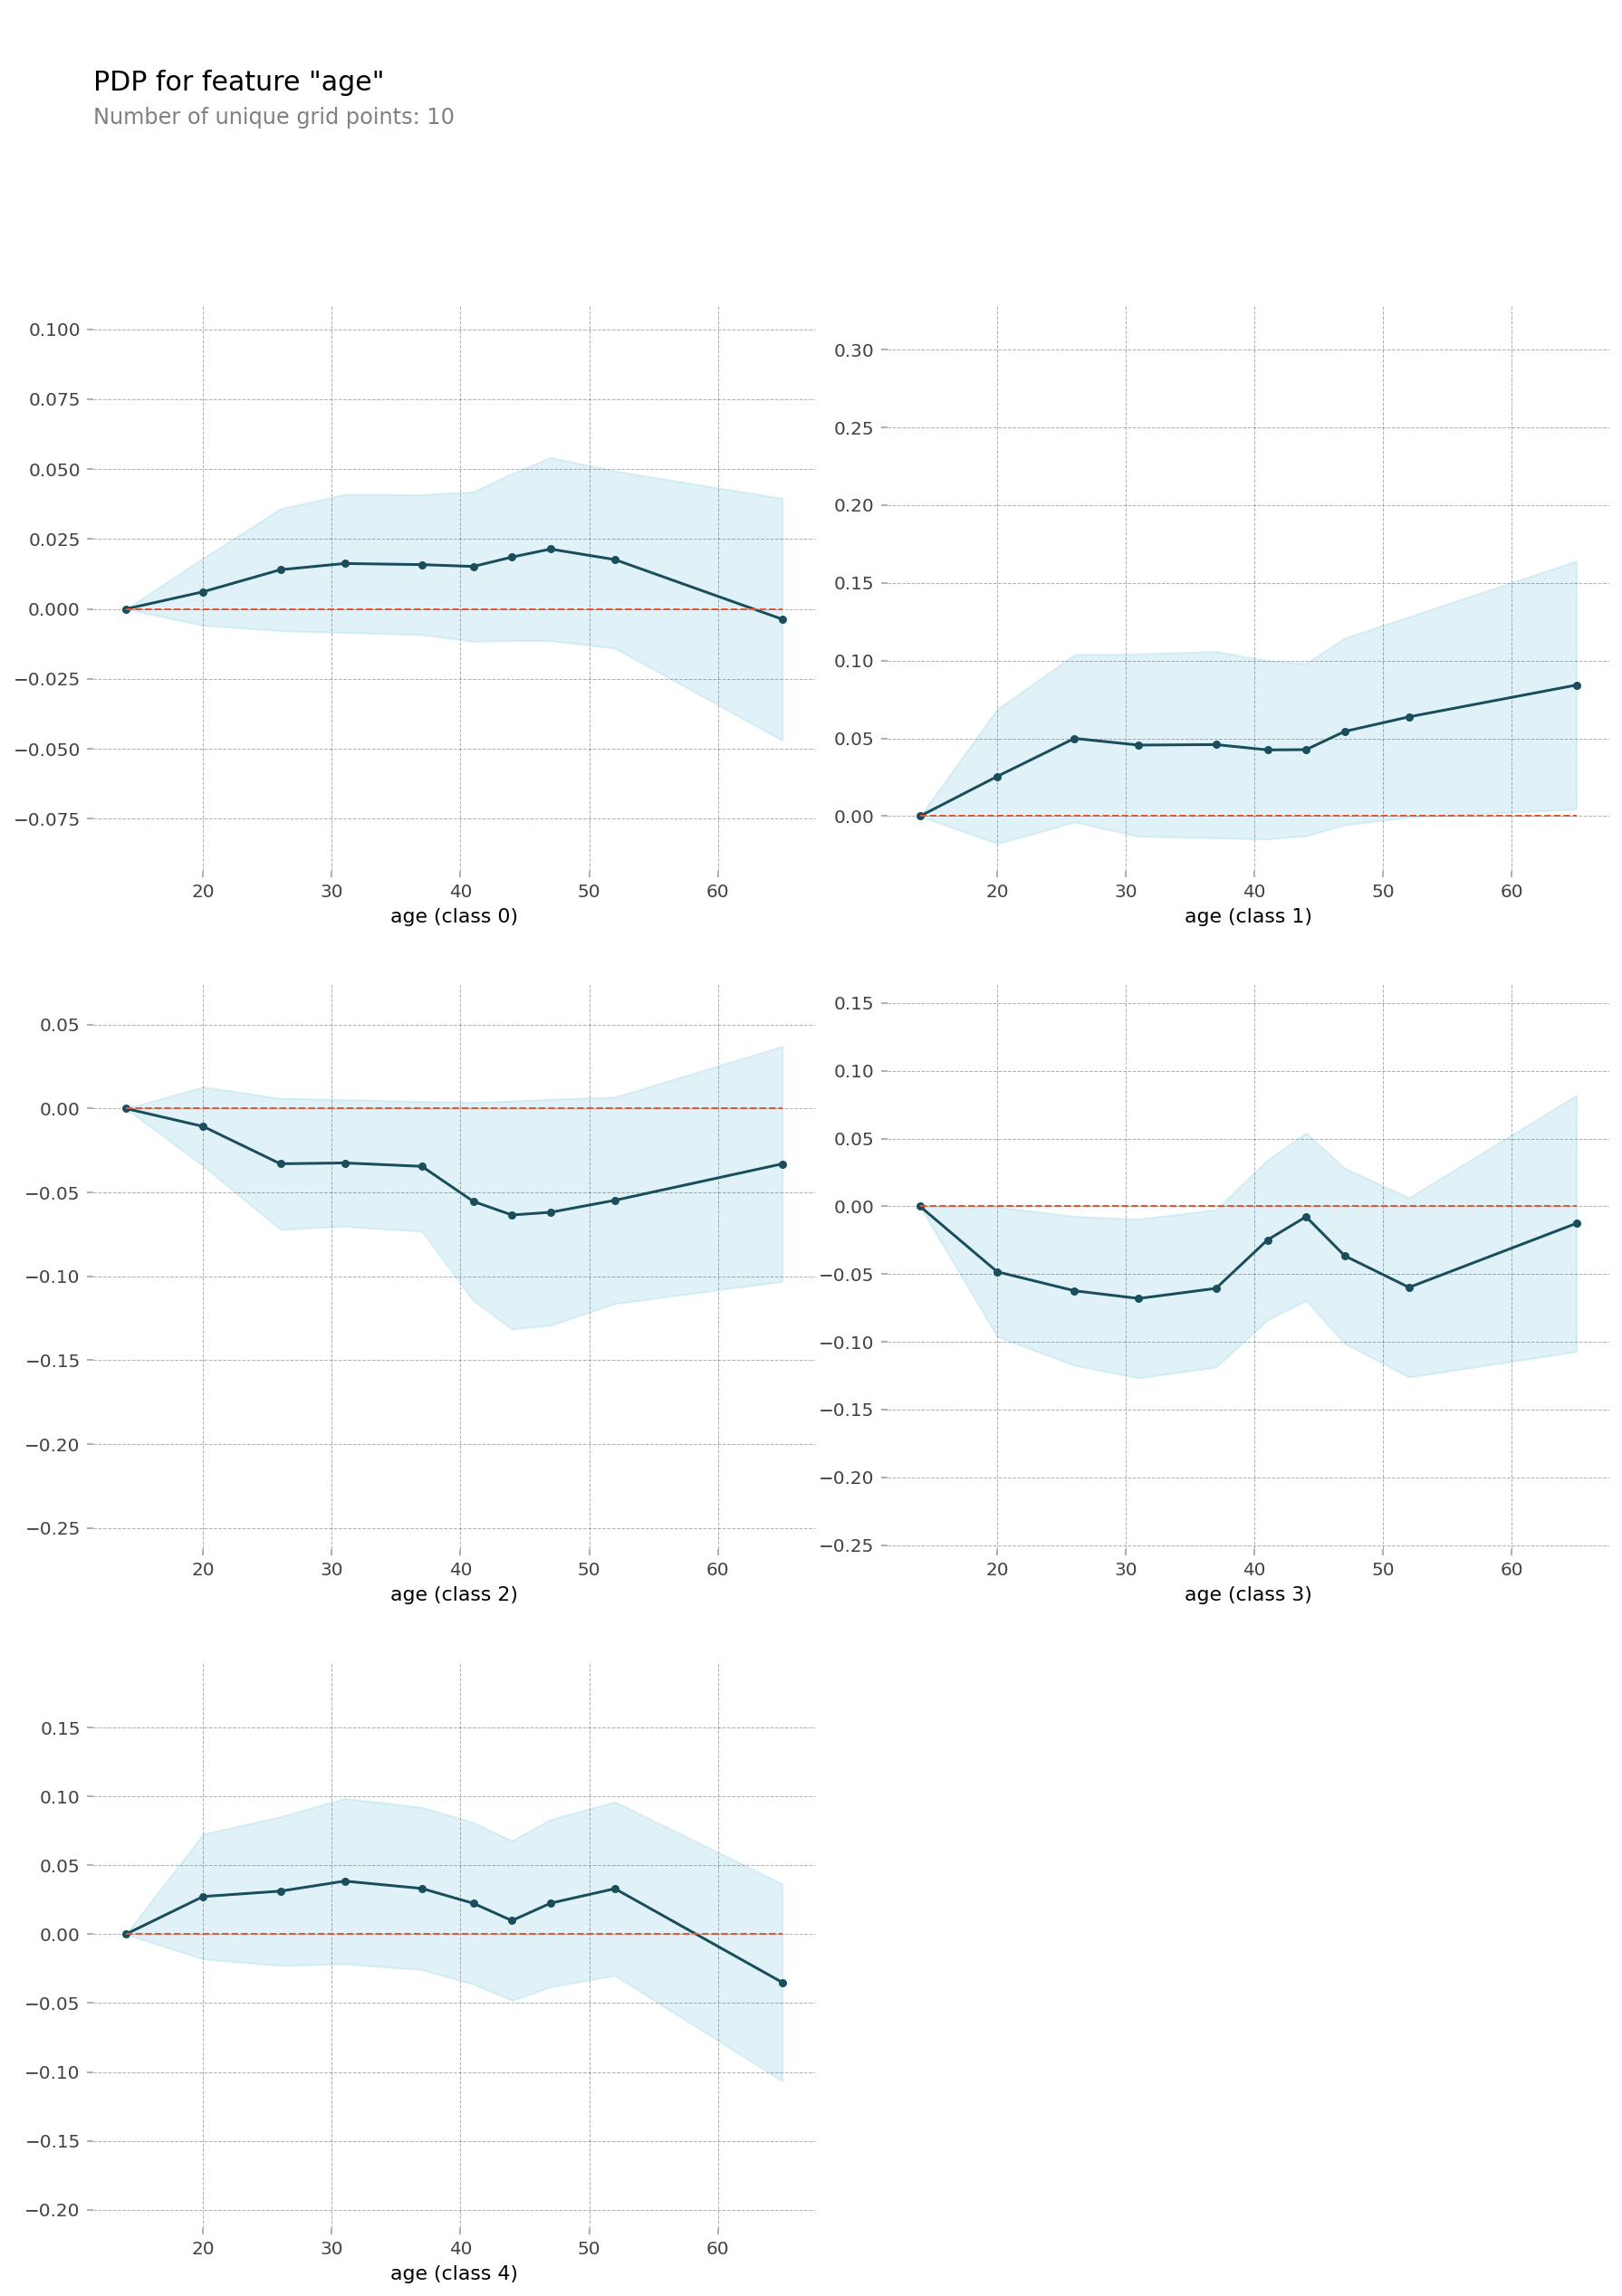

In [ ]:
pdp_plot(isolated, feature_name=feature1);

클래스 0,1,4를 예측할 때(기본 소득에 부정적 투표, 약간 부정적 투표, 긍정적 투표) 나이는 클래스 예측에 긍정적(positive) 영향을 미친다고 할 수 있습니다. 반대로 클래스 2,3을 예측할 때 나이는 클래스 예측에 부정적(negative) 영향을 미친다고 할 수 있습니다.

### 나이, 교육특성과 타겟의 관계

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
X_val_df.columns

Index(['country_code', 'age', 'gender', 'rural', 'education_level',
       'full_time_job', 'has_childeren', 'awareness', 'effect', 'None',
       'Reduce_anxiety', 'Equality', 'Financial_independence', 'Solidarity',
       'Appreciation', 'Reduce_expenses', 'None_con', 'Discouraging',
       'Dependence', 'Against_merit_system', 'Finance_prob', 'Foreigners_job',
       'Only_needed'],
      dtype='object')

In [ ]:
features = ['age', 'education_level']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_df,
    model_features=X_val_df.columns, 
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


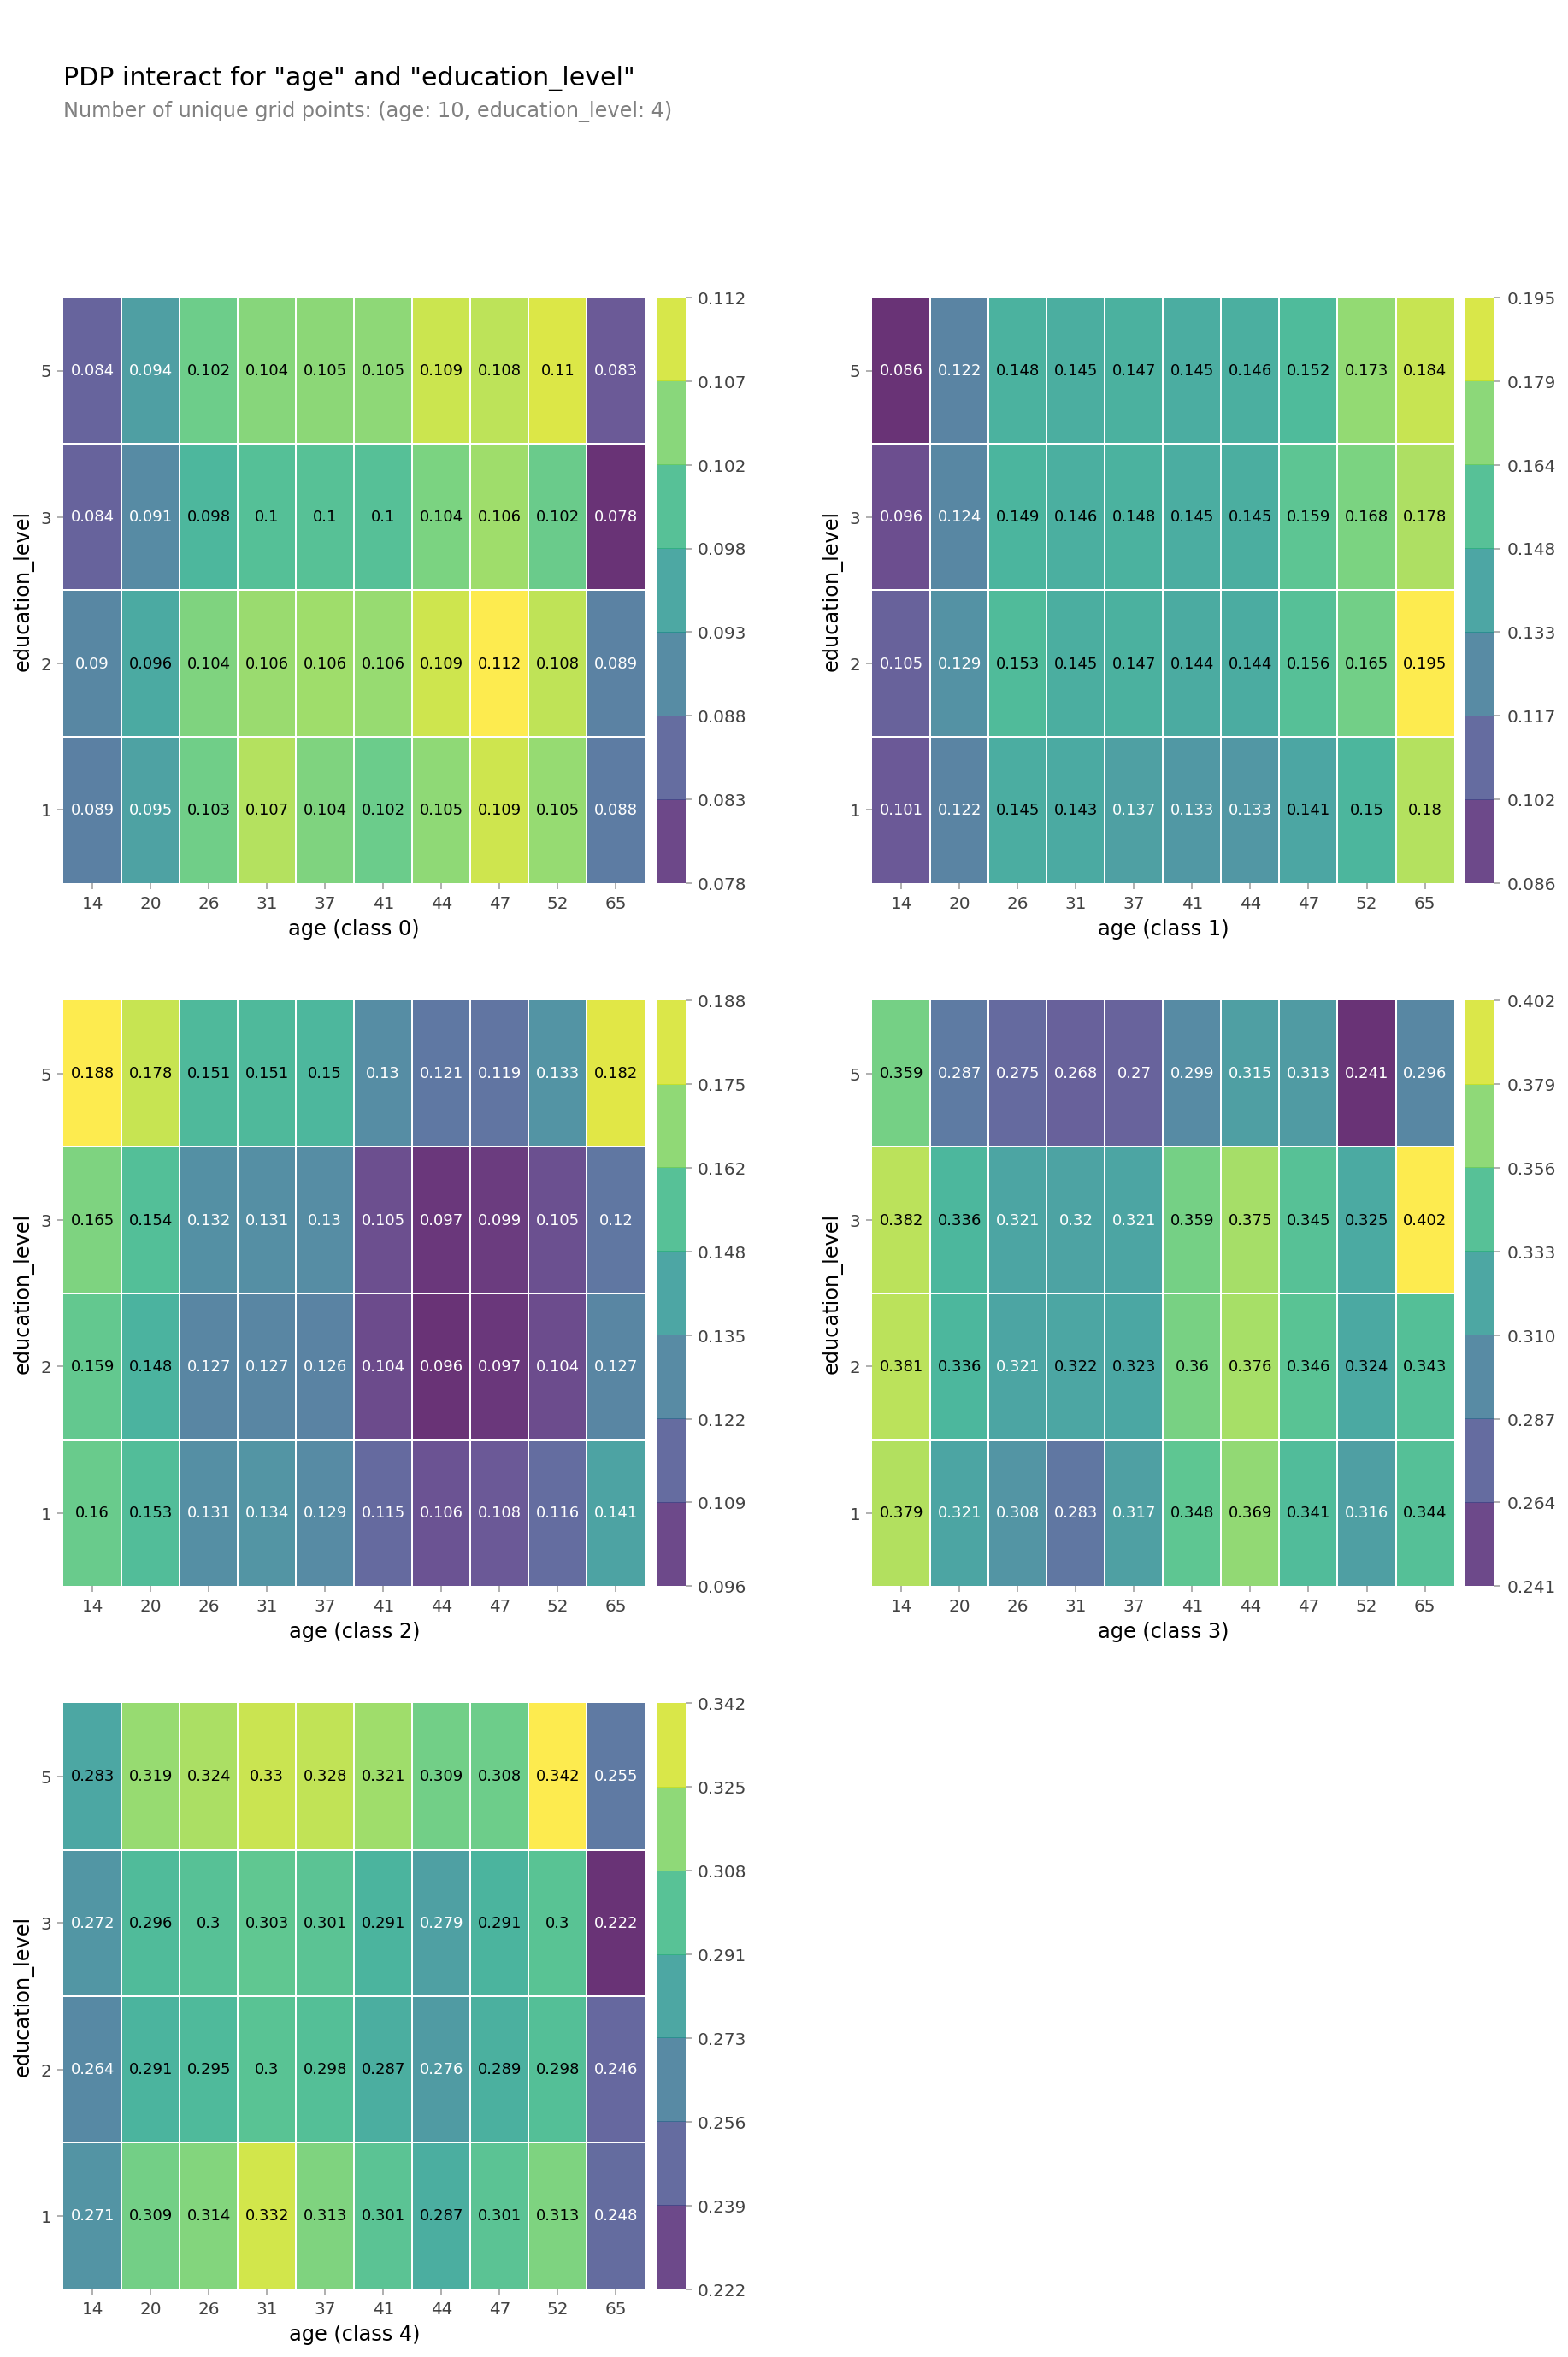

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

교육수준의 클래스는 low는 1, high는 2, medium은 3으로 매핑 되었고 나머지 숫자는 no이거나 nan 입니다. 클래스별로 나이와 교육수준의 관계를 살펴볼 때, 뚜렷한 관계는 알기 어려운 것 같습니다. 다만 class 2 예측에서 교육 수준이 보통이거나 높을 때 40대 이상에서 두 특성 간의 낮은 관계가 나타납니다.

### 개별 샘플 예측의 특성별 중요도 확인
SHAP 라이브러리를 이용해서 샘플 예측에 영향을 미치는 특성들을 살펴보겠습니다.

In [ ]:
!pip install shap

In [ ]:
X_val_df.head(10)

,country_code,age,gender,rural,education_level,full_time_job,has_childeren,awareness,effect,None,Reduce_anxiety,Equality,Financial_independence,Solidarity,Appreciation,Reduce_expenses,None_con,Discouraging,Dependence,Against_merit_system,Finance_prob,Foreigners_job,Only_needed
0,6,53,2,1,1,2,1,2,8,0,0,0,0,0,0,1,0,1,0,1,1,1,1
1,1,63,2,1,1,2,1,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,32,1,1,2,2,2,1,5,0,1,1,1,1,1,1,0,0,0,0,0,1,0
3,19,39,1,2,3,1,1,2,7,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,15,56,1,1,4,1,2,3,3,0,1,1,1,1,1,1,0,0,0,1,0,0,0
5,4,24,1,1,2,2,2,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0
6,5,29,1,1,2,2,1,1,7,0,1,0,0,1,0,0,0,0,1,0,1,0,0
7,17,18,2,1,1,1,2,4,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8,20,45,2,1,3,2,1,3,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0
9,8,30,2,1,1,1,2,1,4,0,0,0,0,0,0,1,0,0,1,0,0,0,0


### 샘플1

In [ ]:
y_val.iloc[2]

4

In [ ]:
row = X_val_df.iloc[[2]]

In [ ]:
model.predict(row)

array([4])

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0],        #multi output:  shap.force_plot(explainer.expected_value[0], shap_values[0])
    features=row
)

3번 샘플은 기본 소득에 긍정적 투표를 하겠다는 사람(class 4)인데, 이렇게 예측하는 데 중요한 특성은 기본 소득의 긍정적 특성을 경제적 자유, 평등, 불안감 해소 라고 평가한 것입니다.

### 샘플 2

연령이 비슷한 4번 샘플을 보겠습니다.

In [ ]:
y_val.iloc[3]

2

In [ ]:
row4 = X_val_df.iloc[[3]]
model.predict(row4)

array([2])

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row4)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0],        #multi output:  shap.force_plot(explainer.expected_value[0], shap_values[0])
    features=row4
)

4번 샘플은 3번과 같은 30대 이지만, 기본소득에 대해 중립적인 의견(class 2)입니다. 이렇게 예측하는데 큰 영향을 준 특성으로는 1) 기본소득의 장점이 예시에 없다 선택,  2) 국적,  3) 기본소득이 평등에 기여함 등이 있습니다.

### 샘플 3

검증 세트 앞에서 100개까지의 샘플로 shap plot을 그려보겠습니다.

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_val_df.iloc[:100])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_val_df.iloc[:100])

그래프에 커서를 가져다 대면 각 샘플별로 분류하는 데 영향을 크게 준 특성들이 보입니다.

### 샘플 4

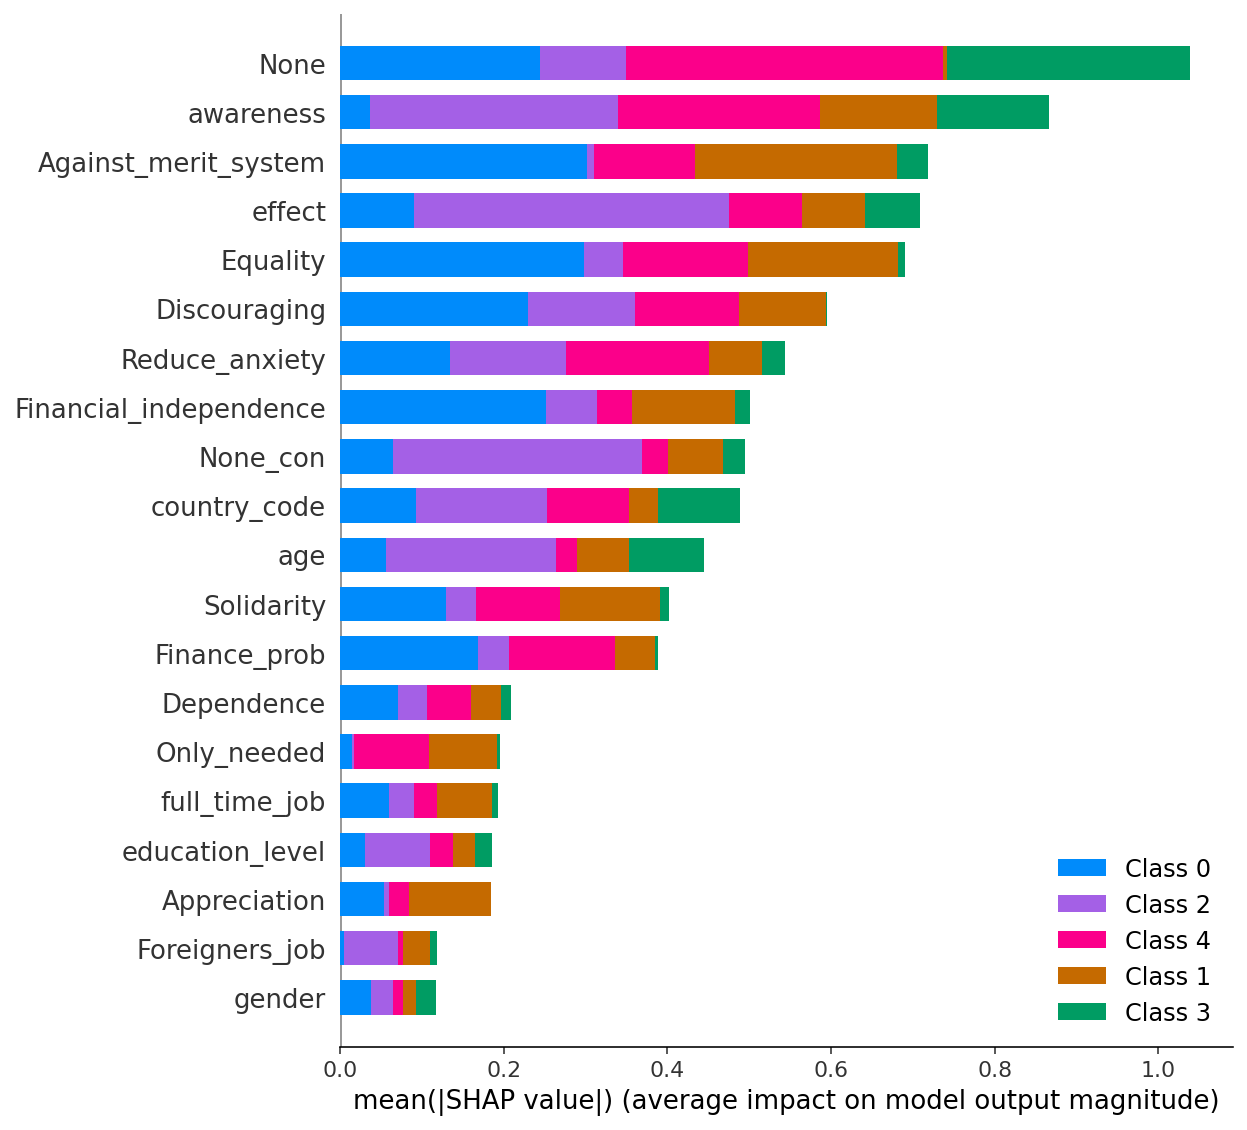

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_val_df.iloc[:300])
shap.summary_plot(shap_values, X_train.iloc[:300])

300개의 샘플로 그려본 분류할 때 중요하게 쓰인 특성들 입니다. 

None, awareness, Against_merit_system, effect, equality 순으로 분류에 중요하게 쓰였는데요, None 같은 경우는 기본 소득의 장점이 예시에 없다는 선택지여서 해석이 어려울 것 같습니다. 그 다음 특성으로는 기본소득의 존재에 대해 알고 있는지 여부, 기본 소득이 능력 기반 시스템에 맞지 않는다는 의견, 기본 소득의 영향에 대한 의견, 기본 소득이 공정한 사회에 기여한다는 장점 등이 있었습니다.